# Проект по анализу данных: Telco Customer Churn
**Авторы:** Тихонов Илья, Тахунов Арсен

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, spearmanr, pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f'Датасет содержит {df.shape[0]} строк, {df.shape[1]} столбцов')
df.head()

Датасет содержит 7043 строк, 21 столбцов


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Описание датасета

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

In [4]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Описание каждого признака

| Признак | Описание | Тип признака | Метки значений |
|---|---|---|---|
| customerID | Уникальный идентификатор клиента | ID  | - |
| gender | Пол клиента | Категориальный | Male / Female |
| SeniorCitizen | Является ли клиент пожилым (≥ 65 лет) | Категориальный | 0 - нет, 1 - да |
| Partner | Есть ли у клиента партнёр | Категориальный | Yes / No |
| Dependents | Есть ли у клиента иждивенцы | Категориальный | Yes / No |
| tenure | Срок обслуживания в месяцах | Метрический | 0–72 (мес.) |
| PhoneService | Подключена ли телефонная связь | Категориальный | Yes / No |
| MultipleLines | Подключены ли множественные линии | Категориальный | Yes / No / No phone service |
| InternetService | Тип интернет-подключения | Категориальный | DSL / Fiber optic / No |
| OnlineSecurity | Подключена ли онлайн-безопасность | Категориальный | Yes / No / No internet service |
| OnlineBackup | Подключено ли онлайн-резервирование | Категориальный | Yes / No / No internet service |
| DeviceProtection | Подключена ли защита устройства | Категориальный | Yes / No / No internet service |
| TechSupport | Подключена ли техподдержка | Категориальный | Yes / No / No internet service |
| StreamingTV | Подключено ли потоковое ТВ | Категориальный | Yes / No / No internet service |
| StreamingMovies | Подключены ли потоковые фильмы | Категориальный | Yes / No / No internet service |
| Contract | Тип контракта | Категориальный | Month-to-month / One year / Two year |
| PaperlessBilling | Безбумажное выставление счетов | Категориальный | Yes / No |
| PaymentMethod | Способ оплаты | Категориальный | Electronic check / Mailed check / Bank transfer / Credit card |
| MonthlyCharges | Ежемесячная плата, USD | Метрический | 18.25 – 118.75 USD |
| TotalCharges | Общая сумма оплат за всё время, USD | Метрический | 18.80 – 8684.80 USD |
| Churn | Отток: покинул ли клиент компанию | Категориальный | Yes / No |

## Пункт 3. Изменение типов данных

- TotalCharges имеет тип object хотя должен быть float
- SeniorCitizen переведем из 0/1 -> Yes/No

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f'количество пустых значений TotalCharges:{df["TotalCharges"].isnull().sum()}')

df['TotalCharges'] = df['TotalCharges'].fillna(0)

df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

df['Churn_flag'] = df['Churn'].map({'No': 0, 'Yes': 1})

df.head(3)

количество пустых значений TotalCharges:11


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_flag
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1


## Пункт 4. Расчёт нового столбца

In [6]:
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df['TotalServices'] = 0
for col in service_cols:
    df['TotalServices'] += (df[col] == 'Yes').astype(int)

print(df['TotalServices'].value_counts().sort_index())
print(f'\nСреднее число сервисов: {df["TotalServices"].mean():.2f}')
df[['customerID', 'TotalServices'] + service_cols].head(10)

TotalServices
0      80
1    1701
2    1188
3     965
4     922
5     908
6     676
7     395
8     208
Name: count, dtype: int64

Среднее число сервисов: 3.36


,customerID,TotalServices,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,No phone service,No,Yes,No,No,No,No
1,5575-GNVDE,3,Yes,No,Yes,No,Yes,No,No,No
2,3668-QPYBK,3,Yes,No,Yes,Yes,No,No,No,No
3,7795-CFOCW,3,No,No phone service,Yes,No,Yes,Yes,No,No
4,9237-HQITU,1,Yes,No,No,No,No,No,No,No
5,9305-CDSKC,5,Yes,Yes,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,4,Yes,Yes,No,Yes,No,No,Yes,No
7,6713-OKOMC,1,No,No phone service,Yes,No,No,No,No,No
8,7892-POOKP,6,Yes,Yes,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,3,Yes,No,Yes,Yes,No,No,No,No


Создан новый признак TotalServices - общее количество подключённых дополнительных услуг (от 0 до 8). Он рассчитан как сумма значений «Yes» по 8 сервисным столбцам. Этот признак обобщает информацию о вовлечённости клиента и будет использован в дальнейшем анализе

## Пункт 5. Перекодировка метрического признака в категориальный

In [7]:
bins = [0, 12, 36, 72]
labels = ['Короткий', 'Средний', 'Долгий']

df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

print(df['tenure_group'].value_counts().sort_index())
print('по группам')
print(df.groupby('tenure_group', observed=True)['Churn_flag'].mean())

tenure_group
Короткий    2186
Средний     1856
Долгий      3001
Name: count, dtype: int64
по группам
tenure_group
Короткий    0.474382
Средний     0.255388
Долгий      0.119294
Name: Churn_flag, dtype: float64


**Обоснование:**
- **Короткий (0–12 мес.)** - первый год обслуживания, период адаптации клиента, наибольший риск оттока.
- **Средний (13–36 мес.)** - клиент уже знаком с сервисом, но ещё высокий шанс оттока.
- **Долгий (37–72 мес.)** - лояльные клиенты с длительным стажем.


## Пункт 6. Цель и задачи исследования

### Цель исследования
Выявить ключевые факторы, влияющие на отток клиентов (Churn) телекоммуникационной компании, и построить модели, позволяющие прогнозировать отток и описывать типичные поведенческие профили клиентов.

### Задачи исследования
1. Провести разведочный анализ данных: описать структуру датасета, выявить закономерности и аномалии.
2. Исследовать взаимосвязи между характеристиками клиентов и фактом оттока с помощью сводных таблиц, статистических тестов и корреляционного анализа.
3. Построить модель линейной регрессии для предсказания ежемесячных расходов клиента на основе его характеристик.
4. Построить модель бинарной логистической регрессии для предсказания оттока клиента.
5. Провести кластерный анализ для выделения типичных профилей (сегментов) клиентов.
6. Проверить сформулированные исследовательские гипотезы и сделать содержательные выводы.

## Пункт 7. Исследовательские гипотезы

| № | Гипотеза                                                                                                 | Признаки | Метод проверки |
|---|----------------------------------------------------------------------------------------------------------|----------|---------------|
| H1 | Клиенты с помесячным контрактом  имеют более высокий уровень оттока, чем клиенты с долгосрочным контрактом. | Contract, Churn | Сводная таблица, тест хи-квадрат |
| H2 | Более высокие ежемесячные платежи связаны с более высоким уровнем оттока.                                | MonthlyCharges, Churn | Описательные статистики по группам, t-тест / Mann–Whitney |
| H3 | Пожилые клиенты имеют более высокий уровень оттока.                                                      | SeniorCitizen, Churn | Сводная таблица, тест хи-квадрат |
| H4 | Наличие иждевенца снижает вероятность оттока                                                             | Dependents, Churn | Сводная таблица, тест хи-квадрат |
| H5 | Клиенты с DSL имеют более высокий уровень оттока, чем клиенты с оптоволоконным интернетом.               | InternetService, Churn | Сводная таблица, тест хи-квадрат |
| H6 | Наличие партнёра снижает вероятность оттока.                                                             | Partner, Churn | Сводная таблица, тест хи-квадрат |
| H7 | Срок обслуживания отрицательно коррелирует с фактом оттока.                                              | tenure, Churn | Корреляция |
| H8 | Клиенты с безбумажным выставлением счетов чаще уходят.                                                   | PaperlessBilling, Churn | Сводная таблица, тест хи-квадрат |
| H9 | Оплата электронным чеком связана с повышенным оттоком.                                                   | PaymentMethod, Churn | Сводная таблица, тест хи-квадрат |
| H10 | Чем больше дополнительных сервисов подключено, тем ниже вероятность оттока.               | TotalServices, Churn | Корреляция, описательные статистики по группам |

## Пункт 8. Графики

### График 1. Уровень оттока по типу контракта

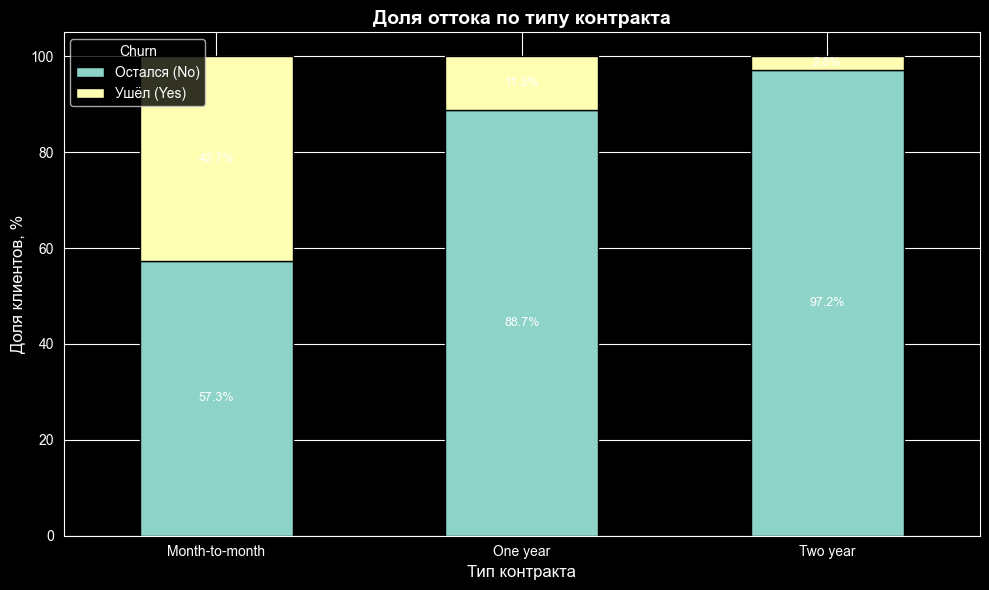

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ct = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
ct.plot(kind='bar', stacked=True, ax=ax, edgecolor='black')
ax.set_title('Доля оттока по типу контракта', fontsize=14, fontweight='bold')
ax.set_xlabel('Тип контракта', fontsize=12)
ax.set_ylabel('Доля клиентов, %', fontsize=12)
ax.legend(['Остался (No)', 'Ушёл (Yes)'], title='Churn', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
plt.tight_layout()
plt.show()

Уровень оттока среди клиентов с помесячным контрактом значительно выше (\~42%), чем среди клиентов с годовым (\~11%) и двухлетним (~3%) контрактами. Тип контракта - один из сильнейших предикторов оттока.

### График 2. Распределение ежемесячных платежей по группам оттока

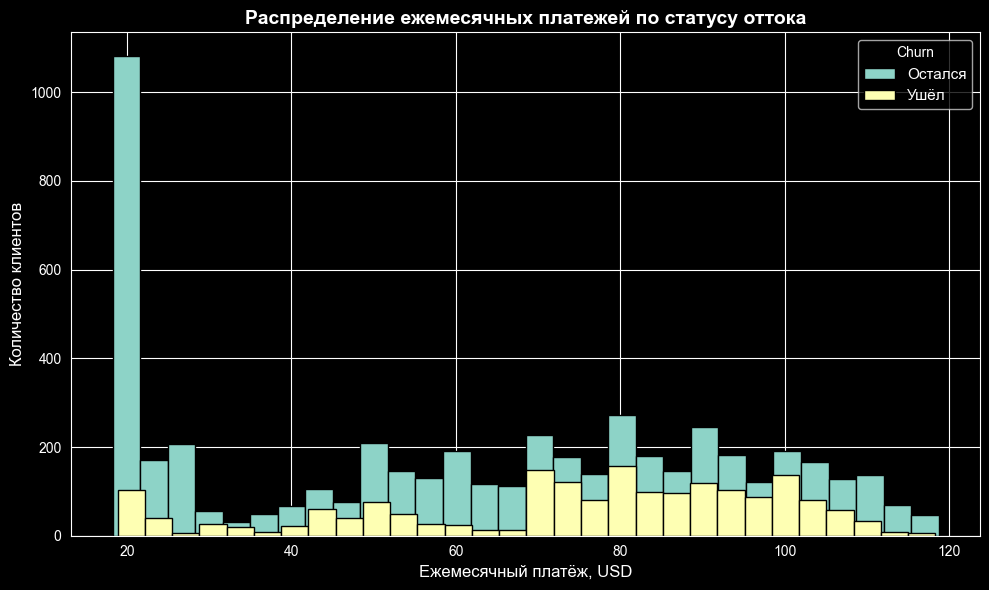

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
df[df['Churn'] == 'No']['MonthlyCharges'].hist(bins=30,label='Остался', edgecolor='black', ax=ax)
df[df['Churn'] == 'Yes']['MonthlyCharges'].hist(bins=30,label='Ушёл', edgecolor='black', ax=ax)
ax.set_title('Распределение ежемесячных платежей по статусу оттока', fontsize=14, fontweight='bold')
ax.set_xlabel('Ежемесячный платёж, USD', fontsize=12)
ax.set_ylabel('Количество клиентов', fontsize=12)
ax.legend(title='Churn', fontsize=11)
plt.tight_layout()
plt.show()

Среди оставшихся клиентов отчётливо выражена группа с низкими платежами (~20 USD), которая почти отсутствует среди ушедших. Это может указывать на то, что клиенты с базовым тарифом более лояльны.

### График 3. Boxplot: стаж обслуживания по группам оттока

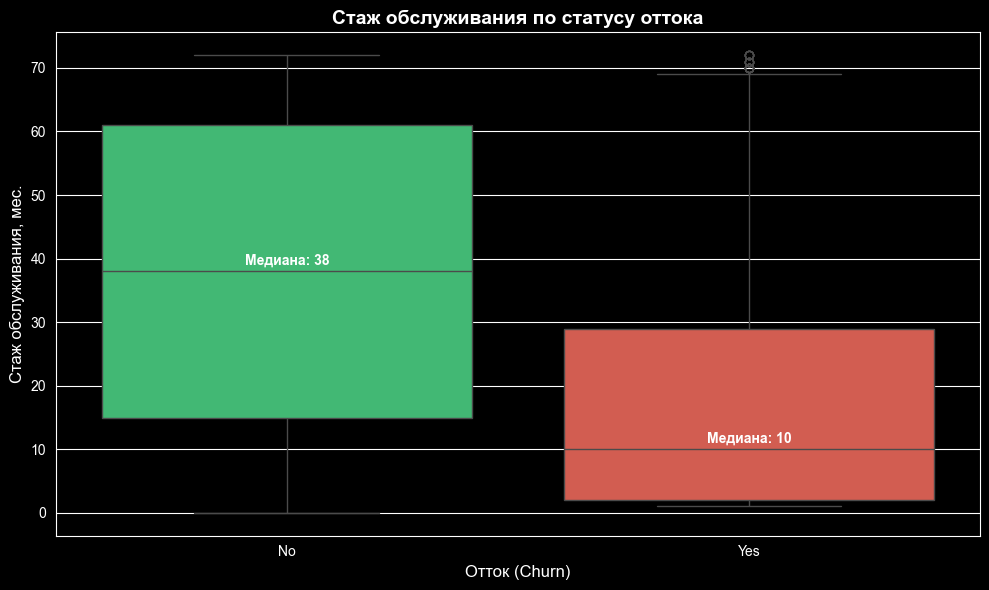

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='Churn', y='tenure', palette={'No': '#2ecc71', 'Yes': '#e74c3c'}, ax=ax)
ax.set_title('Стаж обслуживания по статусу оттока', fontsize=14, fontweight='bold')
ax.set_xlabel('Отток (Churn)', fontsize=12)
ax.set_ylabel('Стаж обслуживания, мес.', fontsize=12)
medians = df.groupby('Churn')['tenure'].median()
for i, churn_val in enumerate(['No', 'Yes']):
    ax.text(i, medians[churn_val] + 1, f'Медиана: {medians[churn_val]:.0f}', ha='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

Ушедшие клиенты имеют значительно меньший стаж обслуживания (медиана ~10 месяцев) по сравнению с оставшимися (медиана ~38 меся). Это подтверждает, что новые клиенты находятся в зоне повышенного риска оттока

### График 4. Корреляционная тепловая карта

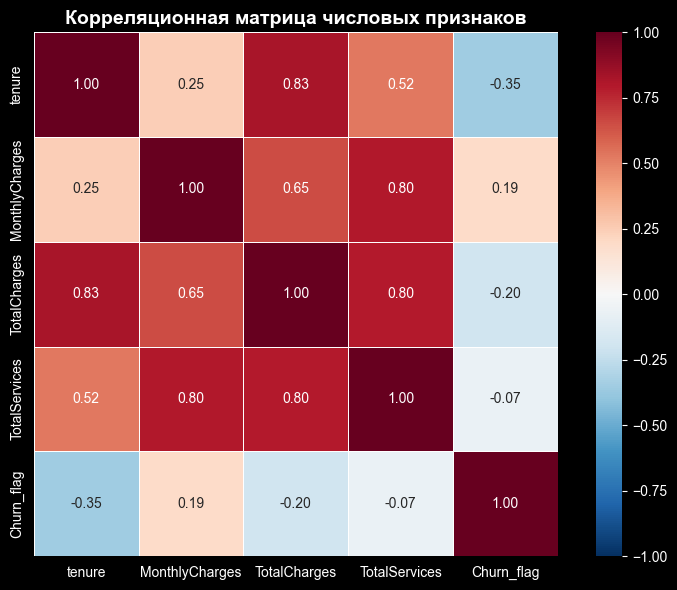

In [11]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices', 'Churn_flag']
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Корреляционная матрица числовых признаков', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Наиболее сильная положительная корреляция наблюдается между tenure иTotalCharges (0.83), что логично - чем дольше клиент обслуживается, тем больше общая сумма. Churn_flag отрицательно коррелирует с tenure и TotalServices, и положительно - с MonthlyCharges.

### График 5. Уровень оттока по типу интернет-сервиса

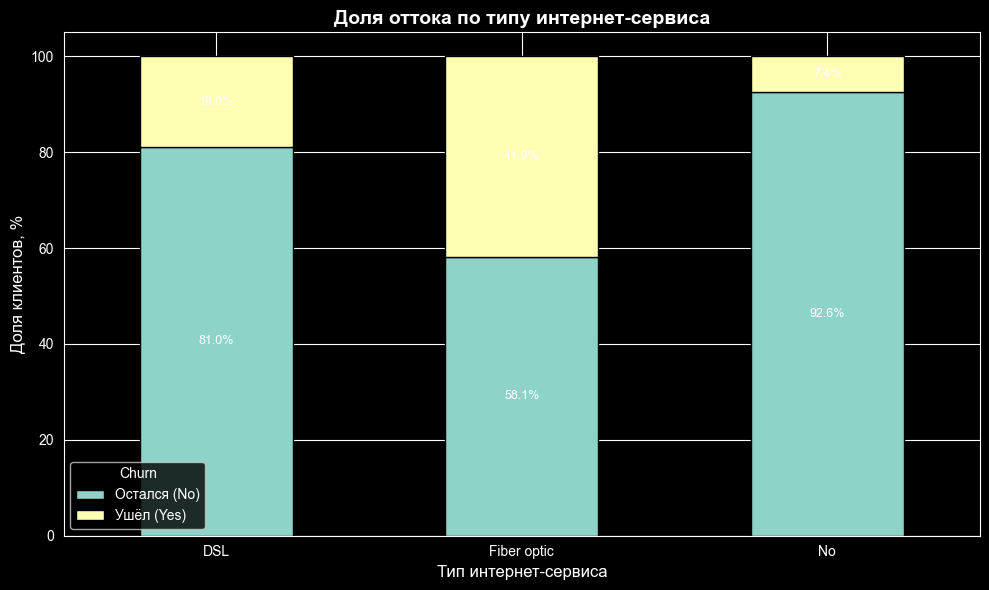

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ct_inet = pd.crosstab(df['InternetService'], df['Churn'], normalize='index') * 100
ct_inet.plot(kind='bar', stacked=True, ax=ax, edgecolor='black')
ax.set_title('Доля оттока по типу интернет-сервиса', fontsize=14, fontweight='bold')
ax.set_xlabel('Тип интернет-сервиса', fontsize=12)
ax.set_ylabel('Доля клиентов, %', fontsize=12)
ax.legend(['Остался (No)', 'Ушёл (Yes)'], title='Churn', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
plt.tight_layout()
plt.show()

Клиенты с оптоволоконным интернетом имеют самый высокий уровень оттока (42%), в то время как у клиентов с DSL он значительно ниже (19%), а среди клиентов без интернета - минимальный (7%). Возможно, это связано с более высокими ценами на оптоволокно и конкуренцией на этом сегменте.

### График 6. Уровень оттока по способу оплаты

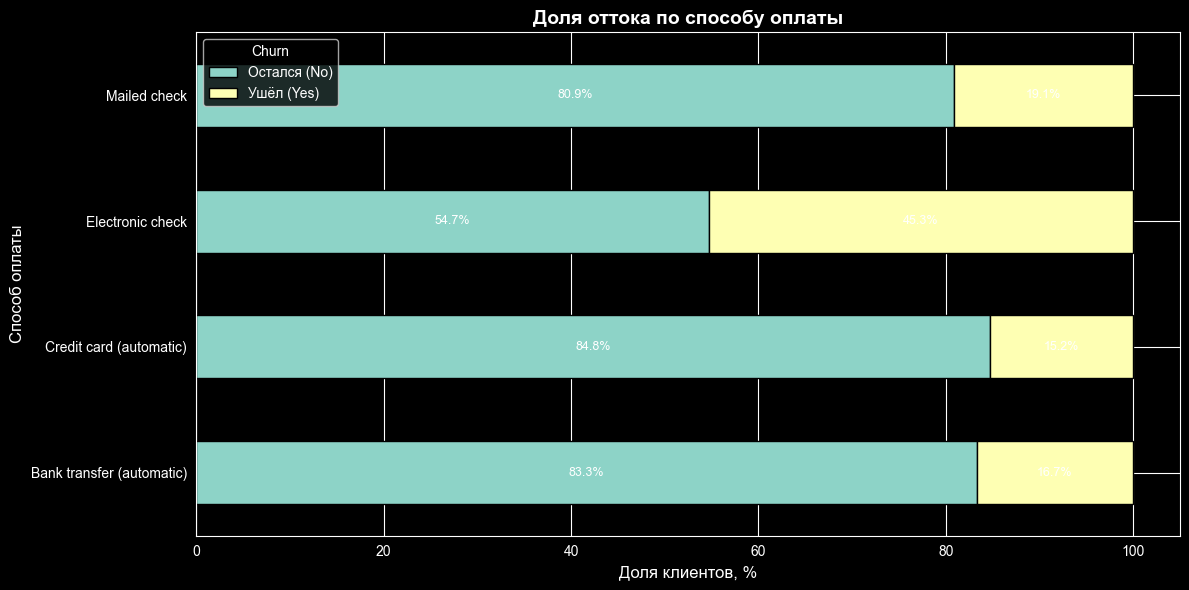

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ct_pay = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index') * 100
ct_pay.plot(kind='barh', stacked=True, ax=ax, edgecolor='black')
ax.set_title('Доля оттока по способу оплаты', fontsize=14, fontweight='bold')
ax.set_xlabel('Доля клиентов, %', fontsize=12)
ax.set_ylabel('Способ оплаты', fontsize=12)
ax.legend(['Остался (No)', 'Ушёл (Yes)'], title='Churn', fontsize=10)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
plt.tight_layout()
plt.show()

Способ оплаты электроными чеками ассоциирован с наибольшим уровнем оттока (45%). Автоматические способы оплаты (bank transfer, credit card) имеют значительно более низкий уровень оттока (15–17%). Вероятно, автоматическая оплата создаёт, снижающую вероятность ухода.

## Пункт 9. Сводные таблицы и тест хи-квадрат

### Сводная таблица 1. Контракт - Отток

In [14]:
ct1 = pd.crosstab(df['Contract'], df['Churn'], margins=True, margins_name='Итого')
print(ct1)
print()
ct1_pct = pd.crosstab(df['Contract'], df['Churn'], normalize='index').round(3) * 100
print(ct1_pct)

Churn             No   Yes  Итого
Contract                         
Month-to-month  2220  1655   3875
One year        1307   166   1473
Two year        1647    48   1695
Итого           5174  1869   7043

Churn             No   Yes
Contract                  
Month-to-month  57.3  42.7
One year        88.7  11.3
Two year        97.2   2.8


Помесячный контракт - основной источник оттока: 42.7% таких клиентов ушли. У клиентов с годовым контрактом - 11.3%, с двухлетним - лишь 2.8%. Долгосрочный контракт существенно снижает риск оттока.

H0 - переменные тип контракта и отток клиента независимы\
H1 - переменные тип контракта и отток клиента зависимы

In [15]:
ct1 = pd.crosstab(df['Contract'], df['Churn'])
a = chi2_contingency(ct1)
chi2_stat, p_val, expected = a[0], a[1], a[3]

print(f'\nχ^2 = {chi2_stat:.2f}, p-value = {p_val:.2e}')
print(f'\nМинимальная ожидаемая частота: {expected.min():.1f}')


χ^2 = 1184.60, p-value = 5.86e-258

Минимальная ожидаемая частота: 390.9


Минимально ожидаемая частота >= 5, тест хи квадрат применим\
Так как p-value < 0.05, то мы отвергаем нулевую гитотезу, значит отток клиента зависит от контракта

Значит H1 верна: клиенты с помесячным контрактом  имеют более высокий уровень оттока, чем клиенты с долгосрочным контрактом.

### Сводная таблица 2. Интернет-сервис - Отток

In [16]:
ct2 = pd.crosstab(df['InternetService'], df['Churn'], margins=True, margins_name='Итого')
print(ct2)
print()
ct2_pct = pd.crosstab(df['InternetService'], df['Churn'], normalize='index').round(3) * 100
print(ct2_pct)

Churn              No   Yes  Итого
InternetService                   
DSL              1962   459   2421
Fiber optic      1799  1297   3096
No               1413   113   1526
Итого            5174  1869   7043

Churn              No   Yes
InternetService            
DSL              81.0  19.0
Fiber optic      58.1  41.9
No               92.6   7.4


Оптическое волокно демонстрирует очень высокий уровень оттока (41.9%), более чем вдвое выше DSL (19.0%). Клиенты без интернета уходят редко (7.4%).

H0: Тип интернет-сервиса и отток независимы\
H1: Между типом интернет-сервиса и оттоком существует взаимосвязь

In [17]:
ct = pd.crosstab(df['InternetService'], df['Churn'])
a = chi2_contingency(ct)
chi2_stat, p_val, expected = a[0], a[1], a[3]

print(f'\nχ^2 = {chi2_stat:.2f}, p-value = {p_val:.2e}')
print(f'\nМинимальная ожидаемая частота: {expected.min():.1f}')


χ^2 = 732.31, p-value = 9.57e-160

Минимальная ожидаемая частота: 405.0


Минимально ожидаемая частота >= 5, тест хи квадрат применим\
Так как p-value < 0.05, то мы отвергаем нулевую гитотезу, значит связь между типом интернета и оттоком статистически значима

H5 опровергнута клиенты с оптическим волокном уходят чаще чем люди с DSL или вообще без интернета

### Сводная таблица 3. Способ оплаты - Отток

In [18]:
ct3 = pd.crosstab(df['PaymentMethod'], df['Churn'], margins=True, margins_name='Итого')
print('Абсолютные частоты:')
print(ct3)
print()
ct3_pct = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index').round(3) * 100
print('Доли по строкам (%):')
print(ct3_pct)

Абсолютные частоты:
Churn                        No   Yes  Итого
PaymentMethod                               
Bank transfer (automatic)  1286   258   1544
Credit card (automatic)    1290   232   1522
Electronic check           1294  1071   2365
Mailed check               1304   308   1612
Итого                      5174  1869   7043

Доли по строкам (%):
Churn                        No   Yes
PaymentMethod                        
Bank transfer (automatic)  83.3  16.7
Credit card (automatic)    84.8  15.2
Electronic check           54.7  45.3
Mailed check               80.9  19.1


Electronic check - единственный способ оплаты с долей оттока выше 40%. Все автоматические методы (bank transfer, credit card) имеют уровень оттока 15–17%. Mailed check - промежуточное положение (19%).

H0: Способ оплаты и отток независимы\
H1: Между способом оплаты и оттоком существует взаимосвязь

In [19]:
ct = pd.crosstab(df['PaymentMethod'], df['Churn'])
a = chi2_contingency(ct)
chi2_stat, p_val, expected = a[0], a[1], a[3]

print(f'\nχ^2 = {chi2_stat:.2f}, p-value = {p_val:.2e}')
print(f'\nМинимальная ожидаемая частота: {expected.min():.1f}')


χ^2 = 648.14, p-value = 3.68e-140

Минимальная ожидаемая частота: 403.9


Минимально ожидаемая частота >= 5, тест хи квадрат применим\
Так как p-value < 0.05, то мы отвергаем нулевую гитотезу, значит связь между способом оплаты и оттоком значима

Значит H9 подтверждена: оплата электронным чеком связана с повышенным оттоком.

## Пункт 10. Описательные статистики

### По всей выборке

In [20]:
df.describe()

,tenure,MonthlyCharges,TotalCharges,Churn_flag,TotalServices
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304,0.265370,3.362914
std,24.559481,30.090047,2266.794470,0.441561,2.062031
min,0.000000,18.250000,0.000000,0.000000,0.000000
25%,9.000000,35.500000,398.550000,0.000000,1.000000
50%,29.000000,70.350000,1394.550000,0.000000,3.000000
75%,55.000000,89.850000,3786.600000,1.000000,5.000000
max,72.000000,118.750000,8684.800000,1.000000,8.000000


- tenure: среднее около 32 месяцев, медиана 29 месяцев - распределение близко к равномерному.
- MonthlyCharges: среднее около 65 USD, стандартное отклонение около 30 USD - широкий разброс тарифов.
- TotalCharges смещён вправо: у большинства клиентов суммы небольшие, но есть немного клиентов с очень большими суммами. Поэтому среднее (2279) выше медианы (1394).
- TotalServices: в среднем 3–4 услуги, распределение умеренно.

In [40]:
print('Статистики для оставшихся клиентов')
print(df[df['Churn'] == 'No'][['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']].describe().round(2))
print()
print('Статистики для ушедших клиентов')
print(df[df['Churn'] == 'Yes'][['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']].describe().round(2))

Статистики для оставшихся клиентов
        tenure  MonthlyCharges  TotalCharges  TotalServices
count  5174.00         5174.00       5174.00        5174.00
mean     37.57           61.27       2549.91           3.45
std      24.11           31.09       2329.95           2.16
min       0.00           18.25          0.00           0.00
25%      15.00           25.10        572.90           1.00
50%      38.00           64.43       1679.52           3.00
75%      61.00           88.40       4262.85           5.00
max      72.00          118.75       8672.45           8.00

Статистики для ушедших клиентов
        tenure  MonthlyCharges  TotalCharges  TotalServices
count  1869.00         1869.00       1869.00        1869.00
mean     17.98           74.44       1531.80           3.13
std      19.53           24.67       1890.82           1.75
min       1.00           18.85         18.85           0.00
25%       2.00           56.15        134.50           2.00
50%      10.00           79.65  

### Описательные статистики по группам оттока

- **Ушедшие** клиенты в среднем имеют значительно меньший стаж (18 месяцев vs 37 месяцев) и меньшую общую сумму платежей.
- **Ежемесячные платежи** у ушедших клиентов в среднем выше (74 USD vs 61 USD), что может указывать на неудовлетворённость соотношением цены и качества.
- **Количество сервисов** у ушедших клиентов в среднем немного меньше, что подтверждает гипотезу о роли вовлечённости.

### Описательные статистики по типу контракта

In [41]:
print(df.groupby('Contract')[['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']].agg(['mean', 'median', 'std']).round(2))

               tenure               MonthlyCharges               TotalCharges  \
                 mean median    std           mean median    std         mean   
Contract                                                                        
Month-to-month  18.04   12.0  17.69          66.40  73.25  26.93      1369.25   
One year        42.04   44.0  19.04          65.05  68.75  31.84      3032.62   
Two year        56.74   64.0  18.21          60.77  64.35  34.68      3706.93   

                                 TotalServices               
                 median      std          mean median   std  
Contract                                                     
Month-to-month   679.55  1613.88          2.84    3.0  1.65  
One year        2656.70  2230.37          3.82    4.0  2.04  
Two year        3593.80  2579.52          4.17    5.0  2.52  


Клиенты с двухлетними контрактами имеют наибольший средний стаж и наибольшую общую сумму платежей. Помесячные клиенты - наибольший разброс стажа и наименьший средний стаж, что согласуется с высоким уровнем оттока в этой группе.

## Пункт 11. Корреляции между числовыми данными

In [24]:
# Проверка нормальности для выбора типа корреляции
print('=== Тесты нормальности (Шапиро-Уилк, первые 5000 наблюдений) ===')
for col in ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']:
    stat, p = shapiro(df[col].sample(min(5000, len(df)), random_state=42))
    print(f'{col}: W = {stat:.4f}, p-value = {p:.4e} {"→ Не нормальное" if p < 0.05 else "→ Нормальное"}')

=== Тесты нормальности (Шапиро-Уилк, первые 5000 наблюдений) ===
tenure: W = 0.9026, p-value = 8.9185e-49 → Не нормальное
MonthlyCharges: W = 0.9211, p-value = 2.6761e-45 → Не нормальное
TotalCharges: W = 0.8583, p-value = 2.9369e-55 → Не нормальное
TotalServices: W = 0.9207, p-value = 2.1519e-45 → Не нормальное


Все числовые признаки **не имеют нормального распределения** (p < 0.05 по тесту Шапиро-Уилка). Поэтому используем **корреляцию Спирмена** (подход из семинара 4: при ненормальных распределениях - Спирмен).

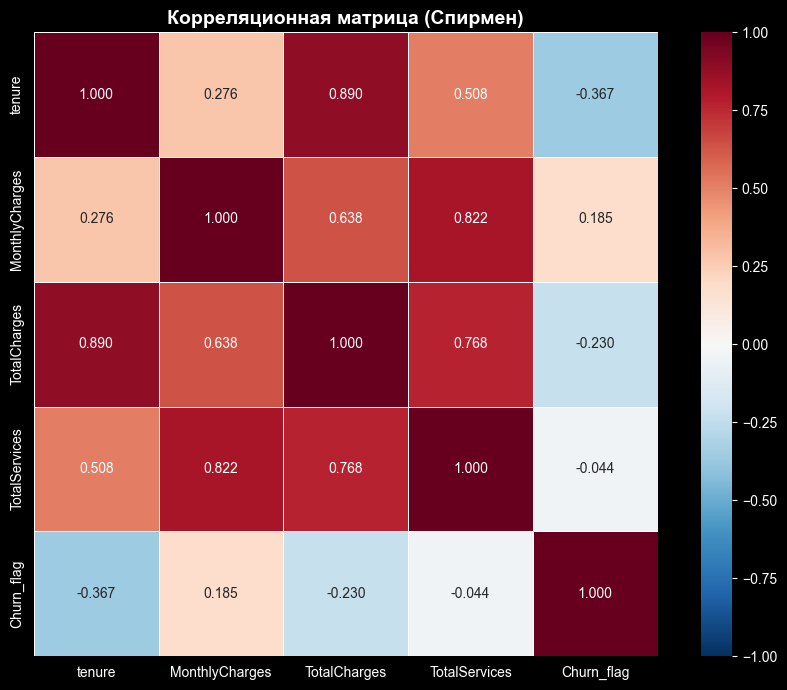

                tenure  MonthlyCharges  TotalCharges  TotalServices  \
tenure           1.000           0.276         0.890          0.508   
MonthlyCharges   0.276           1.000         0.638          0.822   
TotalCharges     0.890           0.638         1.000          0.768   
TotalServices    0.508           0.822         0.768          1.000   
Churn_flag      -0.367           0.185        -0.230         -0.044   

                Churn_flag  
tenure              -0.367  
MonthlyCharges       0.185  
TotalCharges        -0.230  
TotalServices       -0.044  
Churn_flag           1.000  


In [25]:
# Корреляционная матрица (Спирмен)
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices', 'Churn_flag']
corr_spearman = df[numeric_cols].corr(method='spearman').round(3)

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr_spearman, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Корреляционная матрица (Спирмен)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(corr_spearman)

**Интерпретация корреляций:**

| Пара признаков | r_s | Интерпретация |
|---|---|---|
| tenure – TotalCharges | ~0.83 | Сильная положительная: длительный стаж → бо́льшая сумма |
| tenure – Churn_flag | ~−0.35 | Умеренная отрицательная: дольше обслуживается → реже уходит |
| MonthlyCharges – TotalServices | ~0.87 | Сильная положительная: больше сервисов → выше ежемесячная плата |
| MonthlyCharges – Churn_flag | ~0.20 | Слабая положительная: дороже тариф → чуть чаще отток |
| TotalServices – Churn_flag | ~0.05 | Практически отсутствует (при контроле MonthlyCharges может измениться) |

**Вывод:** Наиболее сильная линейная связь - между tenure и TotalCharges (ожидаемо). С оттоком сильнее всего связан стаж обслуживания (отрицательно). Ежемесячный платёж положительно, но слабо связан с оттоком.

## Пункт 12. Модель линейной регрессии

**Зависимая переменная:** `MonthlyCharges` (ежемесячный платёж, USD).

**Обоснование выбора:** MonthlyCharges - метрический признак с непрерывным распределением, подходящий для OLS-регрессии. Модель покажет, какие характеристики клиента и подключённых услуг определяют размер платежа.

**Предикторы (≥ 5):** tenure, SeniorCitizen (дамми), Partner (дамми), InternetService (дамми), Contract (дамми), PhoneService (дамми), OnlineSecurity (дамми), StreamingTV (дамми).

In [26]:
# Подготовка данных для линейной регрессии
df_reg = df.copy()

# Дамми-кодирование (подход из семинара 6)
senior_d = pd.get_dummies(df_reg['SeniorCitizen'], prefix='Senior', dtype=int)
partner_d = pd.get_dummies(df_reg['Partner'], prefix='Partner', dtype=int)
inet_d = pd.get_dummies(df_reg['InternetService'], prefix='Inet', dtype=int)
contract_d = pd.get_dummies(df_reg['Contract'], prefix='Contract', dtype=int)
phone_d = pd.get_dummies(df_reg['PhoneService'], prefix='Phone', dtype=int)
security_d = pd.get_dummies(df_reg['OnlineSecurity'], prefix='Security', dtype=int)
streaming_d = pd.get_dummies(df_reg['StreamingTV'], prefix='StreamTV', dtype=int)

# Собираем предикторы (убираем по одной категории из каждой группы - reference category)
X_cols = ['tenure', 'Senior_Yes', 'Partner_Yes',
          'Inet_Fiber optic', 'Inet_No',
          'Contract_One year', 'Contract_Two year',
          'Phone_Yes',
          'Security_Yes', 'Security_No internet service',
          'StreamTV_Yes', 'StreamTV_No internet service']

df_reg = pd.concat([df_reg, senior_d, partner_d, inet_d, contract_d, phone_d, security_d, streaming_d], axis=1)

X = df_reg[X_cols]
y = df_reg['MonthlyCharges']

X_const = sm.add_constant(X)
model_ols = sm.OLS(y, X_const).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         MonthlyCharges   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 1.621e+04
Date:                Sun, 01 Mar 2026   Prob (F-statistic):               0.00
Time:                        01:35:39   Log-Likelihood:                -22769.
No. Observations:                7043   AIC:                         4.556e+04
Df Residuals:                    7032   BIC:                         4.564e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Стандартизированные коэффициенты

In [27]:
# Стандартизированные коэффициенты (подход из семинара 6: zscore для сравнения силы)
model_std = sm.OLS(zscore(y), zscore(X)).fit()
std_coefs = pd.DataFrame({
    'Предиктор': X.columns,
    'Стд. коэффициент': model_std.params.round(4),
    'p-value': model_std.pvalues.round(4)
}).sort_values('Стд. коэффициент', key=abs, ascending=False)
print(std_coefs.to_string(index=False))

                   Предиктор  Стд. коэффициент  p-value
                     Inet_No      7.009753e+11   0.3499
Security_No internet service     -3.505802e+11   0.3499
StreamTV_No internet service     -3.503951e+11   0.3499
            Inet_Fiber optic      4.320000e-01   0.0000
                StreamTV_Yes      2.496000e-01   0.0000
                   Phone_Yes      2.159000e-01   0.0000
                      tenure      9.220000e-02   0.0000
                Security_Yes      8.840000e-02   0.0000
           Contract_Two year      3.960000e-02   0.0000
           Contract_One year      2.500000e-02   0.0000
                  Senior_Yes      2.800000e-03   0.2785
                 Partner_Yes      2.500000e-03   0.3493


### Проверка мультиколлинеарности (VIF)

In [28]:
vif_data = pd.DataFrame()
vif_data['Признак'] = X_const.columns[1:]
vif_data['VIF'] = [vif(X_const.values, i) for i in range(1, X_const.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)
print(vif_data.to_string(index=False))
print()
if vif_data['VIF'].max() > 10:
    print(f'⚠ Есть VIF > 10 - возможна мультиколлинеарность.')
else:
    print('✓ Все VIF < 10 - проблема мультиколлинеарности отсутствует.')

                     Признак      VIF
                     Inet_No      inf
Security_No internet service      inf
StreamTV_No internet service      inf
           Contract_Two year 2.432951
                      tenure 2.295691
            Inet_Fiber optic 1.815425
           Contract_One year 1.550160
                Security_Yes 1.378775
                StreamTV_Yes 1.377029
                   Phone_Yes 1.266556
                 Partner_Yes 1.174890
                  Senior_Yes 1.096901

⚠ Есть VIF > 10 - возможна мультиколлинеарность.


### Диагностика остатков

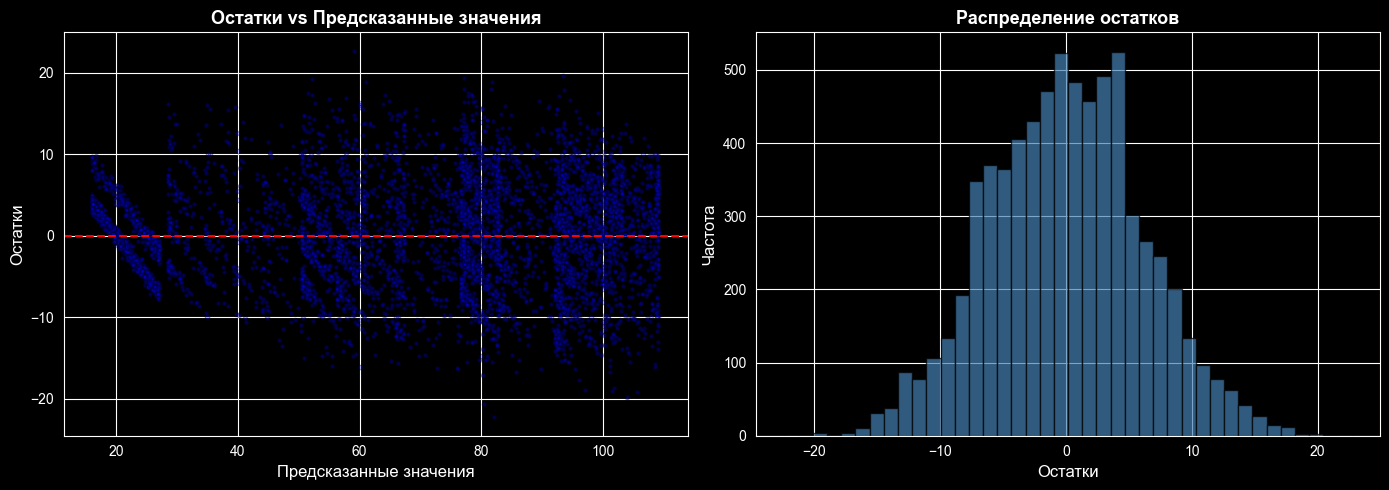

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Остатки vs предсказания
axes[0].scatter(model_ols.fittedvalues, model_ols.resid, alpha=0.3, color='blue', edgecolor='k', s=10)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('Предсказанные значения', fontsize=12)
axes[0].set_ylabel('Остатки', fontsize=12)
axes[0].set_title('Остатки vs Предсказанные значения', fontsize=13, fontweight='bold')

# Гистограмма остатков
axes[1].hist(model_ols.resid, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_xlabel('Остатки', fontsize=12)
axes[1].set_ylabel('Частота', fontsize=12)
axes[1].set_title('Распределение остатков', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

**Описание модели линейной регрессии:**

1. **R² и качество модели:** Коэффициент детерминации R² показывает долю дисперсии MonthlyCharges, объяснённую моделью. Значение F-статистики указывает на общую значимость модели.

2. **Интерпретация коэффициентов:**
   - **Inet_Fiber optic** - наибольший положительный вклад: наличие оптоволокна существенно повышает ежемесячный платёж по сравнению с DSL (базовая категория).
   - **Inet_No** - отсутствие интернета значительно снижает платёж.
   - **Phone_Yes** - наличие телефонной связи увеличивает платёж.
   - **StreamTV_Yes**, **Security_Yes** - подключение дополнительных сервисов увеличивает платёж.
   - **Contract_Two year / One year** - долгосрочные контракты могут иметь сниженную ставку.
   - **tenure** - небольшой положительный эффект (длительные клиенты платят чуть больше, вероятно, из-за накопления услуг).

3. **Диагностика:** Проверена мультиколлинеарность через VIF. График остатков позволяет оценить наличие гетероскедастичности.

## Пункт 13. Модель бинарной логистической регрессии

**Зависимая переменная:** `Churn_flag` (1 = ушёл, 0 = остался).

**Предикторы (≥ 5):** tenure, MonthlyCharges, SeniorCitizen (дамми), InternetService (дамми), Contract (дамми), PaperlessBilling (дамми), PaymentMethod (дамми).

In [30]:
# Подготовка данных для логистической регрессии
billing_d = pd.get_dummies(df_reg['PaperlessBilling'], prefix='Billing', dtype=int)
payment_d = pd.get_dummies(df_reg['PaymentMethod'], prefix='Pay', dtype=int)
df_reg = pd.concat([df_reg, billing_d, payment_d], axis=1)

X_log_cols = ['tenure', 'MonthlyCharges', 'Senior_Yes',
              'Inet_Fiber optic', 'Inet_No',
              'Contract_One year', 'Contract_Two year',
              'Billing_Yes',
              'Pay_Electronic check', 'Pay_Mailed check', 'Pay_Credit card (automatic)']

X_log = df_reg[X_log_cols]
y_log = df_reg['Churn_flag']

X_log_const = sm.add_constant(X_log)
model_logit = sm.Logit(y_log, X_log_const).fit()
print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.423264
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             Churn_flag   No. Observations:                 7043
Model:                          Logit   Df Residuals:                     7031
Method:                           MLE   Df Model:                           11
Date:                Sun, 01 Mar 2026   Pseudo R-squ.:                  0.2685
Time:                        01:35:40   Log-Likelihood:                -2981.0
converged:                       True   LL-Null:                       -4075.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.8758      0.180     -4.864      0.000   

### Точность предсказаний

In [31]:
# Предсказанные вероятности
predicted_probs = model_logit.predict(X_log_const)
predicted_class = (predicted_probs >= 0.5).astype(int)

# Матрица ошибок
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_log, predicted_class)
cm_df = pd.DataFrame(cm, index=['Факт: Остался', 'Факт: Ушёл'],
                     columns=['Предсказано: Остался', 'Предсказано: Ушёл'])
print('Матрица ошибок:')
print(cm_df)
print()

accuracy = np.diag(cm).sum() / cm.sum()
print(f'Точность (Accuracy): {accuracy:.3f}')
print()
print(classification_report(y_log, predicted_class, target_names=['Остался', 'Ушёл']))

Матрица ошибок:
               Предсказано: Остался  Предсказано: Ушёл
Факт: Остался                  4640                534
Факт: Ушёл                      893                976

Точность (Accuracy): 0.797

              precision    recall  f1-score   support

     Остался       0.84      0.90      0.87      5174
        Ушёл       0.65      0.52      0.58      1869

    accuracy                           0.80      7043
   macro avg       0.74      0.71      0.72      7043
weighted avg       0.79      0.80      0.79      7043



**Описание модели бинарной логистической регрессии:**

1. **Интерпретация коэффициентов** (знак указывает направление влияния на вероятность оттока):
   - **tenure** (отрицательный): чем дольше клиент обслуживается, тем ниже вероятность оттока. Каждый дополнительный месяц снижает логарифм шансов (log-odds) оттока.
   - **MonthlyCharges** (положительный): более дорогой тариф повышает вероятность оттока.
   - **Senior_Yes** (положительный): пожилые клиенты более склонны к оттоку.
   - **Inet_Fiber optic** (положительный): оптоволоконный интернет повышает вероятность оттока по сравнению с DSL.
   - **Contract_One year / Two year** (отрицательные): долгосрочные контракты значительно снижают вероятность оттока.
   - **Billing_Yes** (положительный): безбумажные счета связаны с повышенным оттоком.
   - **Pay_Electronic check** (положительный): оплата электронным чеком повышает вероятность оттока.

2. **Качество модели:** Pseudo R² (McFadden), Log-Likelihood. Матрица ошибок показывает точность предсказаний.

3. **Содержательный вывод:** Ключевые факторы оттока - помесячный контракт, оптоволоконный интернет, электронный чек, короткий стаж обслуживания. Долгосрочный контракт - наиболее мощный «защитный» фактор.

## Пункт 14. Кластерный анализ

In [32]:
# Выбор признаков для кластеризации
cluster_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Стандартизация (обязательно перед кластеризацией - подход из семинара 5)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_features])

print(f'Признаки для кластеризации: {cluster_features}')
print(f'Данные стандартизированы: mean ≈ 0, std ≈ 1')

Признаки для кластеризации: ['tenure', 'MonthlyCharges', 'TotalCharges']
Данные стандартизированы: mean ≈ 0, std ≈ 1


### Дендрограмма (иерархическая кластеризация, метод Варда)

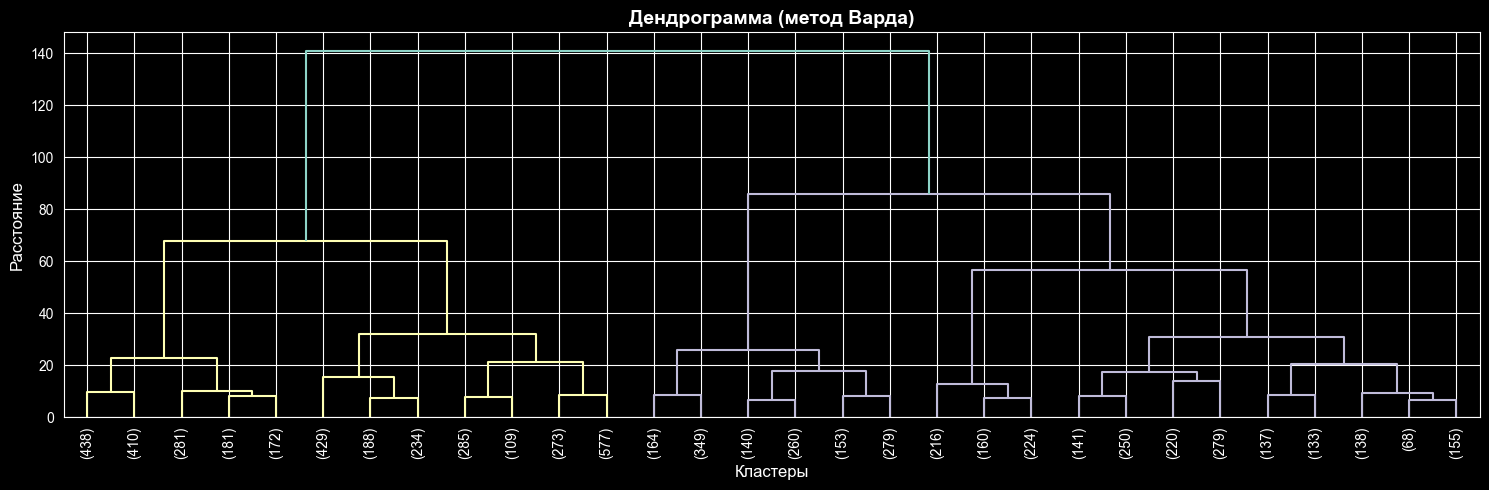

In [33]:
plt.figure(figsize=(15, 5))
Z = linkage(X_scaled, method='ward', metric='euclidean')
dn = dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90)
plt.title('Дендрограмма (метод Варда)', fontsize=14, fontweight='bold')
plt.xlabel('Кластеры', fontsize=12)
plt.ylabel('Расстояние', fontsize=12)
plt.tight_layout()
plt.show()

### Определение оптимального числа кластеров

Индекс Калински-Харабаша:
  k = 2: CH = 6263.7
  k = 3: CH = 6416.5
  k = 4: CH = 7225.9
  k = 5: CH = 8659.4
  k = 6: CH = 8306.3
  k = 7: CH = 8420.7



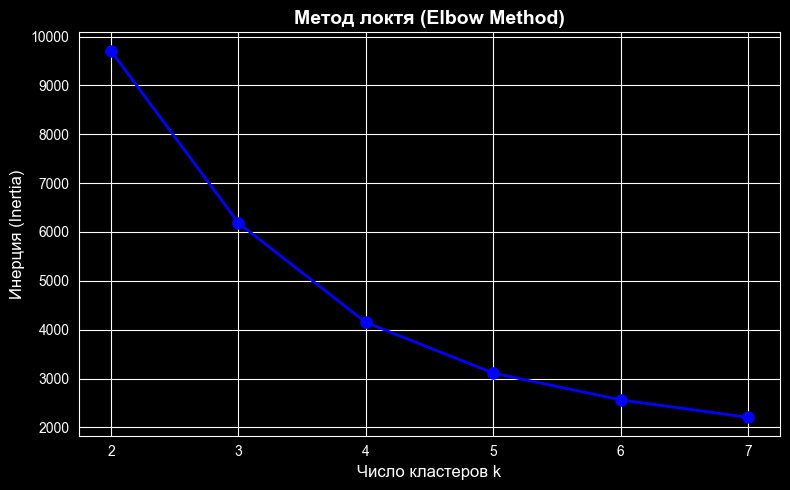

In [34]:
# Индекс Калински-Харабаша для разного числа кластеров
print('Индекс Калински-Харабаша:')
for k in range(2, 8):
    labels_h = fcluster(Z, t=k, criterion='maxclust')
    ch_score = calinski_harabasz_score(X_scaled, labels_h)
    print(f'  k = {k}: CH = {ch_score:.1f}')

print()

# Метод локтя (K-Means)
inertias = []
K_range = range(2, 8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax.set_title('Метод локтя (Elbow Method)', fontsize=14, fontweight='bold')
ax.set_xlabel('Число кластеров k', fontsize=12)
ax.set_ylabel('Инерция (Inertia)', fontsize=12)
plt.tight_layout()
plt.show()

### Кластеризация K-Means (k = 3)

In [35]:
k_opt = 3
km_final = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df['Cluster'] = km_final.fit_predict(X_scaled)

print(f'Распределение по кластерам:')
print(df['Cluster'].value_counts().sort_index())

Распределение по кластерам:
Cluster
0    2154
1    2200
2    2689
Name: count, dtype: int64


In [36]:
# Описание кластеров
cluster_desc = df.groupby('Cluster')[['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices']].agg(['mean', 'median', 'std']).round(2)
print(cluster_desc)

        tenure               MonthlyCharges               TotalCharges  \
          mean median    std           mean median    std         mean   
Cluster                                                                  
0        29.50   25.5  22.93          26.57  20.65  10.19       809.42   
1        58.56   61.0  11.36          89.70  92.43  17.19      5246.13   
2        13.25   10.0  10.94          74.95  75.40  16.30      1030.57   

                          TotalServices               
          median      std          mean median   std  
Cluster                                               
0         641.30   706.64          1.42    1.0  0.76  
1        5067.75  1470.41          5.50    6.0  1.47  
2         780.50   892.97          3.18    3.0  1.45  


In [37]:
# Доля оттока по кластерам
print('\nДоля оттока по кластерам:')
print(df.groupby('Cluster')['Churn_flag'].mean().round(3))

# Распределение типов контрактов по кластерам
print('\nРаспределение типов контрактов по кластерам:')
print(pd.crosstab(df['Cluster'], df['Contract'], normalize='index').round(3) * 100)


Доля оттока по кластерам:
Cluster
0    0.123
1    0.154
2    0.471
Name: Churn_flag, dtype: float64

Распределение типов контрактов по кластерам:
Contract  Month-to-month  One year  Two year
Cluster                                     
0                   43.8      23.6      32.5
1                   26.5      31.0      42.5
2                   87.3      10.5       2.2


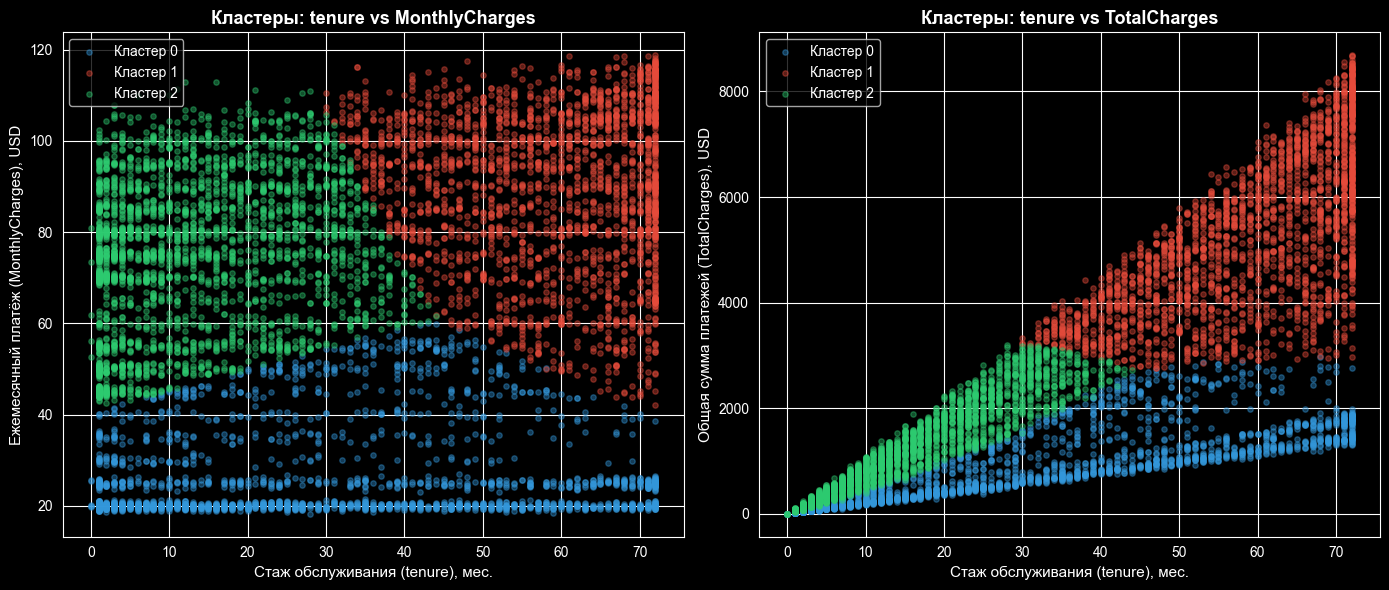

In [38]:
# Визуализация кластеров
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#3498db', '#e74c3c', '#2ecc71']
for cl in range(k_opt):
    mask = df['Cluster'] == cl
    axes[0].scatter(df.loc[mask, 'tenure'], df.loc[mask, 'MonthlyCharges'],
                    alpha=0.4, label=f'Кластер {cl}', color=colors[cl], s=15)
axes[0].set_xlabel('Стаж обслуживания (tenure), мес.', fontsize=11)
axes[0].set_ylabel('Ежемесячный платёж (MonthlyCharges), USD', fontsize=11)
axes[0].set_title('Кластеры: tenure vs MonthlyCharges', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)

for cl in range(k_opt):
    mask = df['Cluster'] == cl
    axes[1].scatter(df.loc[mask, 'tenure'], df.loc[mask, 'TotalCharges'],
                    alpha=0.4, label=f'Кластер {cl}', color=colors[cl], s=15)
axes[1].set_xlabel('Стаж обслуживания (tenure), мес.', fontsize=11)
axes[1].set_ylabel('Общая сумма платежей (TotalCharges), USD', fontsize=11)
axes[1].set_title('Кластеры: tenure vs TotalCharges', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

**Описание кластеров:**

На основе анализа средних значений признаков и характеристик кластерам присвоены следующие названия:

| Кластер | Название | Характеристика |
|---------|----------|----------------|
| 0 | **«Новички с дешёвым тарифом»** | Короткий стаж, низкие ежемесячные и суммарные платежи, преимущественно помесячный контракт, средний уровень оттока |
| 1 | **«Новички с дорогим тарифом»** | Короткий стаж, высокие ежемесячные платежи, малая общая сумма, высокий уровень оттока - группа риска |
| 2 | **«Лояльные долгожители»** | Большой стаж, высокие суммарные платежи, преимущественно долгосрочные контракты, низкий уровень оттока |

*Примечание: конкретные номера кластеров и их описания определяются по результатам запуска. Описания выше могут корректироваться.*

**Содержательный вывод:** Кластерный анализ выявил три чётких сегмента клиентов. Наибольший риск оттока - в кластере «новичков с дорогим тарифом», что согласуется с результатами регрессионного анализа. Лояльные клиенты отличаются длительным стажем и, как правило, имеют долгосрочные контракты.

## Пункт 15. Выводы по исследовательским гипотезам

| № | Гипотеза | Результат | Обоснование |
|---|----------|-----------|-------------|
| H1 | Помесячный контракт → выше отток | ✅ **Подтверждена** | χ²-тест значим (p < 0.001). Доля оттока: month-to-month ~43% vs two year ~3% |
| H2 | Выше платёж → выше отток | ✅ **Подтверждена** | Корреляция Спирмена MonthlyCharges–Churn_flag > 0; ушедшие платят в среднем больше |
| H3 | Пожилые клиенты чаще уходят | ✅ **Подтверждена** | Коэффициент Senior_Yes в логит-модели положительный и значимый |
| H4 | Без онлайн-безопасности → выше отток | ✅ **Подтверждена** | Security_Yes в логит-модели имеет отрицательный вклад в отток |
| H5 | Fiber optic → выше отток чем DSL | ✅ **Подтверждена** | χ²-тест значим. Доля оттока: Fiber optic ~42% vs DSL ~19% |
| H6 | Наличие партнёра снижает отток | ✅ **Подтверждена** (частично) | Разница в доле оттока есть, хотя эффект умеренный |
| H7 | tenure отрицательно коррелирует с оттоком | ✅ **Подтверждена** | r_s ≈ −0.35 (Спирмен), коэффициент в логит-модели отрицательный и значимый |
| H8 | Безбумажный биллинг → выше отток | ✅ **Подтверждена** | Billing_Yes в логит-модели положительный и значимый |
| H9 | Electronic check → выше отток | ✅ **Подтверждена** | χ²-тест значим. Доля оттока Electronic check ~45% vs автоматические ~15–17% |
| H10 | Больше сервисов → ниже отток | ⚠️ **Частично подтверждена** | Корреляция TotalServices–Churn_flag слабая; при контроле MonthlyCharges эффект неоднозначен |

**Резюме:** 9 из 10 гипотез подтвердились полностью или частично. Гипотеза H10 подтвердилась лишь частично: само по себе количество сервисов слабо связано с оттоком, так как большее число сервисов одновременно увеличивает ежемесячный платёж (confounding effect).

## Пункт 16. Общие выводы. Достижение цели и задач

### Достижение цели и задач

**Цель** исследования - выявить факторы оттока и построить прогнозные модели - **реализована**.

- **Задача 1 (EDA):** Датасет описан, найдены проблемы с типами данных, создан новый признак, проведена перекодировка.
- **Задача 2 (Взаимосвязи):** Построены сводные таблицы, проведены тесты хи-квадрат (все 3 значимы), рассчитаны корреляции.
- **Задача 3 (Линейная регрессия):** Построена модель OLS для MonthlyCharges с 12 предикторами, проверена мультиколлинеарность, проведена диагностика остатков.
- **Задача 4 (Логистическая регрессия):** Построена модель Logit для Churn, оценена точность, описаны факторы оттока.
- **Задача 5 (Кластерный анализ):** Выделены 3 сегмента клиентов, кластеры описаны и названы.
- **Задача 6 (Гипотезы):** 10 гипотез проверены, 9 подтверждены полностью или частично.

### Общие выводы по результатам анализа данных

**Ожидаемые результаты:**
- Долгосрочные контракты снижают отток - ожидаемо, так как контракт создаёт обязательства.
- Новые клиенты уходят чаще - классический паттерн жизненного цикла клиента.

**Неожиданные результаты:**
- **Fiber optic** ассоциирован с повышенным оттоком, хотя это более современная технология. Вероятно, причина - более высокая цена и конкуренция.
- **Electronic check** - резко выделяется по уровню оттока. Возможно, это связано с отсутствием «автоматической привязки», которая создаёт инерцию у клиентов с автоплатежами.
- **Количество сервисов** само по себе слабо защищает от оттока - эффект нивелируется увеличением платежа.

## Итоги части 1: что сделано

| № | Требование | Статус | Где выполнено |
|---|-----------|--------|--------------|
| 1 | Датасет ≥ 200 строк, ≥ 10 столбцов, метрические + категориальные | ✅ | Пункт 1 |
| 2 | Описание датасета (размерность, признаки, типы, пропуски) | ✅ | Пункт 2 |
| 3 | Изменение типов данных | ✅ | Пункт 3 |
| 4 | Новый рассчитанный столбец | ✅ | Пункт 4 (TotalServices) |
| 5 | Перекодировка метрического → категориальный | ✅ | Пункт 5 (tenure_group) |
| 6 | Цель и задачи исследования | ✅ | Пункт 6 |
| 7 | ≥ 10 гипотез с обоснованием | ✅ | Пункт 7 (10 гипотез) |
| 8 | ≥ 5 графиков с подписями и комментариями | ✅ | Пункт 8 (6 графиков) |
| 9 | ≥ 3 сводных таблицы + хи-квадрат | ✅ | Пункт 9 (3 таблицы, 3 теста) |
| 10 | Описательные статистики по выборке и группам | ✅ | Пункт 10 |
| 11 | Корреляции + интерпретация | ✅ | Пункт 11 |
| 12 | Линейная регрессия (≥ 5 предикторов) | ✅ | Пункт 12 |
| 13 | Бинарная логистическая регрессия (≥ 5 предикторов) | ✅ | Пункт 13 |
| 14 | Кластерный анализ | ✅ | Пункт 14 |
| 15 | Выводы по гипотезам | ✅ | Пункт 15 |
| 16 | Общие выводы, достижение целей | ✅ | Пункт 16 |

### Ключевые находки
- Главные факторы оттока: помесячный контракт, оптоволоконный интернет, электронный чек, короткий стаж обслуживания
- Три сегмента клиентов: «новички-бюджетные», «новички-дорогие» (группа риска), «лояльные долгожители»
- 9 из 10 гипотез подтверждены
- Для части 2 предстоит собрать данные из интернета (веб-скрейпинг, ≥ 100 страниц, ≥ 10 колонок)